In [ ]:
# !kaggle competitions download -c tabular-playground-series-mar-2021

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

In [4]:
data=pd.read_csv('data/train.csv')
data.head()

,id,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,...,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,target
0,0,A,I,A,B,B,BI,A,S,Q,...,0.759439,0.795549,0.681917,0.621672,0.592184,0.791921,0.815254,0.965006,0.665915,0
1,1,A,I,A,A,E,BI,K,W,AD,...,0.386385,0.541366,0.388982,0.357778,0.600044,0.408701,0.399353,0.927406,0.493729,0
2,2,A,K,A,A,E,BI,A,E,BM,...,0.343255,0.616352,0.793687,0.552877,0.352113,0.388835,0.412303,0.292696,0.549452,0
3,3,A,K,A,C,E,BI,A,Y,AD,...,0.831147,0.807807,0.800032,0.619147,0.221789,0.897617,0.633669,0.760318,0.934242,0
4,4,A,I,G,B,E,BI,C,G,Q,...,0.338818,0.277308,0.610578,0.128291,0.578764,0.279167,0.351103,0.357084,0.328960,1


In [3]:
data.dtypes

id          int64
cat0       object
cat1       object
cat2       object
cat3       object
cat4       object
cat5       object
cat6       object
cat7       object
cat8       object
cat9       object
cat10      object
cat11      object
cat12      object
cat13      object
cat14      object
cat15      object
cat16      object
cat17      object
cat18      object
cont0     float64
cont1     float64
cont2     float64
cont3     float64
cont4     float64
cont5     float64
cont6     float64
cont7     float64
cont8     float64
cont9     float64
cont10    float64
target      int64
dtype: object

In [3]:
le=LabelEncoder()
from sklearn.preprocessing import OrdinalEncoder 
for col in data.columns:
    if data[col].dtype=='object':
        le=LabelEncoder()
        le.fit(data[col])
        data[col]=le.transform(data[col])
        
test=pd.read_csv('data/test.csv')
test_submisstion=test.drop('id',axis=1)
data=data.drop('id',axis=1)

le=LabelEncoder()
for col in test_submisstion.columns:
    if test_submisstion[col].dtype=='object':
        test_submisstion[col]=le.fit_transform(test_submisstion[col])
        
# standardize the data
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
features=data.drop('target',axis=1)
labels=data['target']
features_scaled=scaler.fit_transform(features)
features_scaled=pd.DataFrame(features_scaled,columns=features.columns)
test_scaled=scaler.transform(test_submisstion)

data.head()

,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,target
0,0,8,0,1,1,33,0,44,54,0,...,0.759439,0.795549,0.681917,0.621672,0.592184,0.791921,0.815254,0.965006,0.665915,0
1,0,8,0,0,4,33,8,48,3,5,...,0.386385,0.541366,0.388982,0.357778,0.600044,0.408701,0.399353,0.927406,0.493729,0
2,0,10,0,0,4,33,0,30,38,9,...,0.343255,0.616352,0.793687,0.552877,0.352113,0.388835,0.412303,0.292696,0.549452,0
3,0,10,0,2,4,33,0,50,3,5,...,0.831147,0.807807,0.800032,0.619147,0.221789,0.897617,0.633669,0.760318,0.934242,0
4,0,8,6,1,4,33,2,32,54,0,...,0.338818,0.277308,0.610578,0.128291,0.578764,0.279167,0.351103,0.357084,0.328960,1


In [4]:
data['target'].unique()

array([0, 1])

In [5]:
# logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(features_scaled,labels,test_size=0.2,random_state=12)
logreg=LogisticRegression()
logreg.fit(X_train,y_train)
y_pred=logreg.predict_proba(X_test)[:,-1]
# roc_auc score
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test,y_pred)


0.8674203442248626

In [22]:
from xgboost import XGBClassifier
params={'learning_rate':0.08,'n_estimators':1000,'max_depth':10,'min_child_weight': 103,'gamma':0.0001,'colsample_bytree':0.8,'objective':'binary:logistic','eval_metric':'auc','seed':0,'tree_method':'gpu_hist'}
xgb=XGBClassifier(**params)
xgb.fit(X_train,y_train,early_stopping_rounds=50,eval_set=[(X_test,y_test)],verbose=False)
y_pred=xgb.predict_proba(X_test)[:,-1]
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test,y_pred)

/home/studio-lab-user/.conda/envs/stat/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


0.8942635282603721

In [25]:
pred=xgb.predict_proba(test_scaled)[:,-1]
sample_submission=pd.read_csv('data/sample_submission.csv')
sample_submission['target']=pred
sample_submission.to_csv('submission.csv',index=False)

In [26]:
import tensorflow as tf 
def create_model():
    model=tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(100,activation='swish',input_shape=(X_train.shape[1],)))
    model.add(tf.keras.layers.Dense(100,activation='swish'))
    model.add(tf.keras.layers.Dense(1,activation='sigmoid'))
    # roc auc score
    metrics=[tf.keras.metrics.AUC(name='auc')]
    model.compile(optimizer='adam',loss='binary_crossentropy',
                    metrics=metrics)
    
    return model

early_stop=tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5)
reduce_lr=tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=3)
callbacks=[early_stop,reduce_lr]

model=create_model()
model.fit(X_train,y_train,epochs=100,validation_data=(X_test,y_test),callbacks=callbacks,batch_size=1028,verbose=2)

Epoch 1/100
234/234 - 2s - loss: 0.3884 - auc: 0.8620 - val_loss: 0.3736 - val_auc: 0.8736 - lr: 0.0010 - 2s/epoch - 11ms/step
Epoch 2/100
234/234 - 1s - loss: 0.3718 - auc: 0.8745 - val_loss: 0.3708 - val_auc: 0.8756 - lr: 0.0010 - 810ms/epoch - 3ms/step
Epoch 3/100
234/234 - 1s - loss: 0.3694 - auc: 0.8763 - val_loss: 0.3693 - val_auc: 0.8769 - lr: 0.0010 - 809ms/epoch - 3ms/step
Epoch 4/100
234/234 - 1s - loss: 0.3679 - auc: 0.8775 - val_loss: 0.3684 - val_auc: 0.8776 - lr: 0.0010 - 806ms/epoch - 3ms/step
Epoch 5/100
234/234 - 1s - loss: 0.3663 - auc: 0.8786 - val_loss: 0.3675 - val_auc: 0.8783 - lr: 0.0010 - 817ms/epoch - 3ms/step
Epoch 6/100
234/234 - 1s - loss: 0.3654 - auc: 0.8793 - val_loss: 0.3662 - val_auc: 0.8790 - lr: 0.0010 - 809ms/epoch - 3ms/step
Epoch 7/100
234/234 - 1s - loss: 0.3645 - auc: 0.8798 - val_loss: 0.3666 - val_auc: 0.8794 - lr: 0.0010 - 808ms/epoch - 3ms/step
Epoch 8/100
234/234 - 1s - loss: 0.3639 - auc: 0.8803 - val_loss: 0.3649 - val_auc: 0.8800 - lr: 0.

Unable to get validation accuracy greater then 0.84 by both xgboost and ANN. Test accuracy stand close to 0.77. The reason was i was calculating accuracy score but for this competition we need roc_auc so predict probability. Now after fixing everything XGBoost get scores of 0.88 and it is almost equalent to val score


In [11]:
# lightbgm
from lightgbm import LGBMClassifier
params={'metric': 'auc', 'reg_alpha': 6.010538011450937, 'reg_lambda': 0.031702113663443346, 'colsample_bytree': 0.27,
   'subsample': 0.6, 'learning_rate': 0.05, 'max_depth': 100, 'num_leaves': 100, 'min_child_samples': 216,
   'cat_smooth': 87, 'random_state': 48,'n_estimators': 20000}
lgbm=LGBMClassifier(**params)
lgbm.fit(X_train,y_train)
y_pred=lgbm.predict_proba(X_test)[:,-1]
roc_auc_score(y_test,y_pred)

0.8833654599910128

# hyperparameter using optuna

In [6]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
%%time
# xgboost
import optuna
from xgboost import XGBClassifier

# roc auc score
from sklearn.metrics import roc_auc_score
def objective(trial):
    params={'learning_rate':trial.suggest_loguniform('learning_rate',1e-3,1e-1),'n_estimators':trial.suggest_int('n_estimators',100,3000),'max_depth':trial.suggest_int('max_depth',3,13),'min_child_weight': trial.suggest_int('min_child_weight',30,150),'gamma':trial.suggest_uniform('gamma',0,0.1),'colsample_bytree':trial.suggest_uniform('colsample_bytree',0.5,1),'eval_metric':'auc','seed':0,'tree_method':'gpu_hist','booster': 'gbtree',}
    xgb=XGBClassifier(**params)
    xgb.fit(X_train,y_train,early_stopping_rounds=100,eval_set=[(X_test,y_test)],verbose = False)
    y_pred=xgb.predict_proba(X_test)[:,-1]
    return roc_auc_score(y_test,y_pred)

trial=optuna.create_study(direction='maximize')
trial.optimize(objective,n_trials=15)


[I 2022-07-06 02:44:47,027] A new study created in memory with name: no-name-08e28f68-464a-4603-93d1-50b591216a0d
[I 2022-07-06 02:44:53,050] Trial 0 finished with value: 0.8848663740737355 and parameters: {'learning_rate': 0.00857350982709802, 'n_estimators': 234, 'max_depth': 10, 'min_child_weight': 60, 'gamma': 0.05645112040911722, 'colsample_bytree': 0.570769229200571}. Best is trial 0 with value: 0.8848663740737355.
[I 2022-07-06 02:45:00,578] Trial 1 finished with value: 0.872010967853678 and parameters: {'learning_rate': 0.001183486495162326, 'n_estimators': 1482, 'max_depth': 5, 'min_child_weight': 60, 'gamma': 0.0624524695125179, 'colsample_bytree': 0.7954948919716707}. Best is trial 0 with value: 0.8848663740737355.
[I 2022-07-06 02:45:49,527] Trial 2 finished with value: 0.8888437526572079 and parameters: {'learning_rate': 0.0020891428940476597, 'n_estimators': 2936, 'max_depth': 12, 'min_child_weight': 143, 'gamma': 0.08140632032175193, 'colsample_bytree': 0.519478984279797

In [10]:
# keras with optuna
import tensorflow as tf
import optuna
def objective(trial):
    model=tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(units=trial.suggest_int('units',50,200),activation=trial.suggest_categorical('activation',['relu','swish','tanh']),input_shape=(X_train.shape[1],)))
    model.add(tf.keras.layers.Dense(units=trial.suggest_int('units',50,200),activation=trial.suggest_categorical('activation',['relu','swish','tanh'])))
    model.add(tf.keras.layers.Dense(units=1,activation='sigmoid'))
    # roc auc score
    metrics=[tf.keras.metrics.AUC(name='auc')]
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5)]
    # optimizer=tf.keras.optimizers.Adam(learning_rate=trial.suggest_loguniform('learning_rate',1e-5,1e-1))
    model.compile(optimizer=trial.suggest_categorical('optimizer',['adam','rmsprop']),loss='binary_crossentropy',metrics=metrics)
    model.fit(X_train,y_train,epochs=100,batch_size=1028,verbose=0,callbacks=callbacks,validation_data=(X_test,y_test))
    # predict probabilities
    y_pred=model.predict(X_test)[:,-1]
    return roc_auc_score(y_test,y_pred)

trial=optuna.create_study(direction='maximize')
trial.optimize(objective,n_trials=10)

[I 2022-07-05 03:34:23,196] A new study created in memory with name: no-name-c4df4482-0f9b-4cfb-bf75-fd92da75953a


1875/1875 [==============================] - 2s 1ms/step


[I 2022-07-05 03:34:40,729] Trial 0 finished with value: 0.8762173342984739 and parameters: {'units': 180, 'activation': 'relu', 'optimizer': 'rmsprop'}. Best is trial 0 with value: 0.8762173342984739.


1875/1875 [==============================] - 2s 1ms/step


[I 2022-07-05 03:34:52,871] Trial 1 finished with value: 0.8772186224968367 and parameters: {'units': 162, 'activation': 'relu', 'optimizer': 'adam'}. Best is trial 1 with value: 0.8772186224968367.


1875/1875 [==============================] - 2s 1ms/step


[I 2022-07-05 03:35:16,459] Trial 2 finished with value: 0.8773636466947167 and parameters: {'units': 115, 'activation': 'swish', 'optimizer': 'rmsprop'}. Best is trial 2 with value: 0.8773636466947167.


1875/1875 [==============================] - 2s 1ms/step


[I 2022-07-05 03:35:31,925] Trial 3 finished with value: 0.876571625938369 and parameters: {'units': 158, 'activation': 'swish', 'optimizer': 'rmsprop'}. Best is trial 2 with value: 0.8773636466947167.


1875/1875 [==============================] - 2s 1ms/step


[I 2022-07-05 03:35:45,059] Trial 4 finished with value: 0.8756494662054463 and parameters: {'units': 157, 'activation': 'relu', 'optimizer': 'rmsprop'}. Best is trial 2 with value: 0.8773636466947167.


1875/1875 [==============================] - 2s 1ms/step


[I 2022-07-05 03:36:29,041] Trial 5 finished with value: 0.877067401645959 and parameters: {'units': 82, 'activation': 'swish', 'optimizer': 'adam'}. Best is trial 2 with value: 0.8773636466947167.


1875/1875 [==============================] - 2s 997us/step


[I 2022-07-05 03:36:52,556] Trial 6 finished with value: 0.8773918323447474 and parameters: {'units': 114, 'activation': 'swish', 'optimizer': 'rmsprop'}. Best is trial 6 with value: 0.8773918323447474.


1875/1875 [==============================] - 2s 997us/step


[I 2022-07-05 03:37:09,956] Trial 7 finished with value: 0.8754654036637506 and parameters: {'units': 133, 'activation': 'tanh', 'optimizer': 'rmsprop'}. Best is trial 6 with value: 0.8773918323447474.


1875/1875 [==============================] - 2s 999us/step


[I 2022-07-05 03:37:33,264] Trial 8 finished with value: 0.8766566232669747 and parameters: {'units': 71, 'activation': 'tanh', 'optimizer': 'adam'}. Best is trial 6 with value: 0.8773918323447474.


1875/1875 [==============================] - 2s 989us/step


[I 2022-07-05 03:37:47,710] Trial 9 finished with value: 0.8762709991946617 and parameters: {'units': 168, 'activation': 'relu', 'optimizer': 'adam'}. Best is trial 6 with value: 0.8773918323447474.


In [ ]:
%%time
# catboost
from catboost import CatBoostClassifier
import optuna
def objective(trial):
    params={'learning_rate':trial.suggest_loguniform('learning_rate',1e-3,1e-1),'n_estimators':trial.suggest_int('n_estimators',100,3000),'max_depth':trial.suggest_int('max_depth',3,13), 'max_bin': trial.suggest_int('max_bin', 200, 400),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 300), 'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.0001, 1.0, log = True),'random_seed': 42,
'task_type': 'GPU',
        'loss_function': 'Logloss',
        'eval_metric': 'AUC',
        'bootstrap_type': 'Poisson'}
    cat=CatBoostClassifier(**params)
    cat.fit(X_train,y_train,early_stopping_rounds=100,eval_set=[(X_test,y_test)],verbose = False)
    y_pred=cat.predict_proba(X_test)[:,-1]
    return roc_auc_score(y_test,y_pred)


study=optuna.create_study(direction='maximize')
study.optimize(objective,n_trials=15)

[I 2022-07-06 02:10:49,062] A new study created in memory with name: no-name-dea51e0a-c986-426f-bd3b-bf3bc13767fa
Default metric period is 5 because AUC is/are not implemented for GPU
[I 2022-07-06 02:11:02,889] Trial 0 finished with value: 0.8873943884844422 and parameters: {'learning_rate': 0.01620649592963992, 'n_estimators': 1809, 'max_depth': 6, 'max_bin': 246, 'min_data_in_leaf': 147, 'l2_leaf_reg': 0.036088379500195826}. Best is trial 0 with value: 0.8873943884844422.
Default metric period is 5 because AUC is/are not implemented for GPU
[I 2022-07-06 02:11:09,253] Trial 1 finished with value: 0.8740964005807701 and parameters: {'learning_rate': 0.00513955522168365, 'n_estimators': 141, 'max_depth': 11, 'max_bin': 370, 'min_data_in_leaf': 238, 'l2_leaf_reg': 0.12081090816492218}. Best is trial 0 with value: 0.8873943884844422.
Default metric period is 5 because AUC is/are not implemented for GPU
[I 2022-07-06 02:11:22,943] Trial 2 finished with value: 0.8825532813351126 and param

CPU times: user 7min 23s, sys: 4min 21s, total: 11min 44s
Wall time: 5min 55s


In [ ]:
optuna.visualization.plot_optimization_history(study)

In [12]:
best_params=study.best_params
best_params['task_type']='GPU'
best_params['loss_function']='Logloss'
best_params['eval_metric']='AUC'
best_params['random_seed']=42
best_params['bootstrap_type']='Poisson'


In [13]:
# train catboost on best params
cat=CatBoostClassifier(**best_params)
cat.fit(X_train,y_train,early_stopping_rounds=200,eval_set=[(X_test,y_test)],verbose = False)
y_pred=cat.predict_proba(X_test)[:,-1]
roc_auc_score(y_test,y_pred)


Default metric period is 5 because AUC is/are not implemented for GPU


0.8893850838055012

In [15]:
pred=cat.predict_proba(test_scaled)[:,-1]
sample_submission=pd.read_csv('data/sample_submission.csv')
sample_submission['target']=pred
sample_submission.to_csv('submission.csv',index=False)

In [ ]:
print("wait")

In [ ]:
# kfold 
from sklearn.model_selection import KFold
kf = KFold(n_splits=10, shuffle=True, random_state=42)
X=features_scaled.values
y=labels.values
prediction=np.zeros(len(test_scaled))
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    cat=CatBoostClassifier(**best_params)
    cat.fit(X_train,y_train,early_stopping_rounds=200,eval_set=[(X_test,y_test)],verbose = False)
    y_pred=cat.predict_proba(X_test)[:,-1]
    roc_auc_score(y_test,y_pred)
    prediction+=cat.predict_proba(test_scaled)[:,-1]/10


Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU


Using 10 folds cross validation improves scores by 0.2. Now we are going to try ensembling. Using weighted ensemble improves the scores by 0.1 and public score by 0.2 percent


In [20]:
sample_submission=pd.read_csv('data/sample_submission.csv')
sample_submission['target']=prediction
sample_submission.to_csv('submission.csv',index=False)

In [6]:
from xgboost import XGBClassifier
params={'learning_rate':0.08,'n_estimators':1000,'max_depth':10,'min_child_weight': 103,'gamma':0.0001,'colsample_bytree':0.8,'objective':'binary:logistic','eval_metric':'auc','seed':0,'tree_method':'gpu_hist'}
xgb=XGBClassifier(**params)
xgb.fit(X_train,y_train,early_stopping_rounds=50,eval_set=[(X_test,y_test)],verbose=False)
y_pred=xgb.predict_proba(X_test)[:,-1]
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test,y_pred)

/home/studio-lab-user/.conda/envs/stat/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


0.8918118773347639

In [8]:
best_params={'learning_rate': 0.02080236419829387, 'n_estimators': 1758, 'max_depth': 9, 'max_bin': 224, 'min_data_in_leaf': 69, 'l2_leaf_reg': 0.0024624443620458757}
best_params['task_type']='GPU'
best_params['loss_function']='Logloss'
best_params['eval_metric']='AUC'
best_params['random_seed']=42
best_params['bootstrap_type']='Poisson'
from catboost import CatBoostClassifier

# train catboost on best params
cat=CatBoostClassifier(**best_params)
cat.fit(X_train,y_train,early_stopping_rounds=200,eval_set=[(X_test,y_test)],verbose = False)
y_pred=cat.predict_proba(X_test)[:,-1]
roc_auc_score(y_test,y_pred)



Default metric period is 5 because AUC is/are not implemented for GPU


0.8894878282894676

In [ ]:
# lightbgm
from lightgbm import LGBMClassifier
params={'metric': 'auc', 'reg_alpha': 6.010538011450937, 'reg_lambda': 0.031702113663443346, 'colsample_bytree': 0.27,
   'subsample': 0.6, 'learning_rate': 0.05, 'max_depth': 100, 'num_leaves': 100, 'min_child_samples': 216,
   'cat_smooth': 87, 'random_state': 48,'n_estimators': 20000}
lgbm=LGBMClassifier(**params)
lgbm.fit(X_train,y_train)
y_pred=lgbm.predict_proba(X_test)[:,-1]
roc_auc_score(y_test,y_pred)

In [11]:
# ensembling xgboost, catboost, lightgbm
prediction=(xgb.predict_proba(X_test)[:,-1]+cat.predict_proba(X_test)[:,-1]+lgbm.predict_proba(X_test)[:,-1])/3
roc_auc_score(y_test,prediction)


0.892910810797521

In [19]:
# weighted average
weights=[0.40,0.27,0.27]
prediction=(xgb.predict_proba(X_test)[:,-1]*weights[0]+cat.predict_proba(X_test)[:,-1]*weights[1]+lgbm.predict_proba(X_test)[:,-1]*weights[2])/sum(weights)
roc_auc_score(y_test,prediction)

0.8930056845184117

In [20]:
prediction=(xgb.predict_proba(test_scaled)[:,-1]*weights[0]+cat.predict_proba(test_scaled)[:,-1]*weights[1]+lgbm.predict_proba(test_scaled)[:,-1]*weights[2])/sum(weights)
sample_submission=pd.read_csv('data/sample_submission.csv')
sample_submission['target']=prediction
sample_submission.to_csv('submission.csv',index=False)

In [21]:
# import joblib
# joblib.dump(xgb, 'xgb.pkl')
# joblib.dump(cat, 'cat.pkl')
# joblib.dump(lgbm, 'lgbm.pkl')


['lgbm.pkl']

In [6]:
import joblib

xgb=joblib.load('xgb.pkl')

cat=joblib.load('cat.pkl')
lgbm=joblib.load('lgbm.pkl')

In [ ]:
# stacking classifier
from sklearn.ensemble import StackingClassifier
clf=StackingClassifier(estimators=[('xgb',xgb),('lgbm',lgbm),('cat',cat)],stack_method='predict_proba',verbose=False,n_jobs=-1)
clf.fit(X_train,y_train)
y_pred=clf.predict_proba(X_test)[:,-1]
roc_auc_score(y_test,y_pred)


In [ ]:
y_pred=clf.predict_proba(X_test)[:,-1]
roc_auc_score(y_test,y_pred)

Now try some EDA and feature engineering

In [5]:
df= data.copy()
num_columns=df.select_dtypes(include=['float64']).columns
cat_columns=df.select_dtypes(include=['object']).columns
df[num_columns].describe()

,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10
count,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000
mean,0.504749,0.494073,0.516632,0.474235,0.504848,0.502257,0.488229,0.501739,0.488074,0.469496,0.508230
std,0.206788,0.213037,0.214851,0.216636,0.227474,0.241243,0.211335,0.203496,0.179048,0.194516,0.203393
min,-0.049562,0.084480,0.094493,-0.045316,0.168071,-0.036379,0.005199,0.090901,0.024139,0.214866,0.097789
25%,0.344985,0.317363,0.326047,0.292249,0.279303,0.276442,0.323914,0.353054,0.358915,0.309934,0.368312
50%,0.479650,0.463170,0.471247,0.387564,0.479858,0.554768,0.518089,0.435404,0.410908,0.407477,0.446576
75%,0.637657,0.693992,0.704625,0.644950,0.725779,0.735225,0.608537,0.642023,0.612725,0.586793,0.581957
max,1.004559,1.009958,1.016600,0.952187,0.858578,0.853022,0.966553,1.035818,1.055885,1.005652,1.011331


All numerical values are already normalized!

<AxesSubplot:>

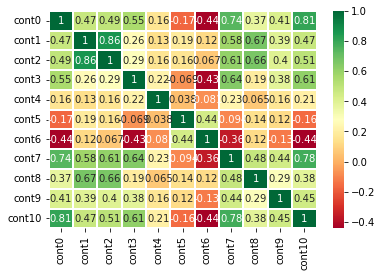

In [6]:
#plot correlation as lower triangle
import seaborn as sns
sns.heatmap(df[num_columns].corr(),annot=True,cmap='RdYlGn',linewidths=0.2)


cont (0,10) (0,7) (1,2) (3,7) (3,10) are correlated

In [ ]:
# removing correlated features
df.drop(['cont2','cont10'],axis=1,inplace=True)
test.drop(['cont2','cont10'],axis=1,inplace=True)
num_columns=df.select_dtypes(include=['float64']).columns
cat_columns=df.select_dtypes(include=['object']).columns

In [6]:
# outlier detection
q1=df.quantile(0.25)
q3=df.quantile(0.75)
iqr=q3-q1
((df<q1-1.5*iqr) | (df>q3+1.5*iqr)).agg([sum, 'mean', 'count'])

/tmp/ipykernel_112/3730083286.py:5: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  ((df<q1-1.5*iqr) | (df>q3+1.5*iqr)).agg([sum, 'mean', 'count'])


,cat0,cat1,cat10,cat11,cat12,cat13,cat14,cat15,cat16,cat17,...,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,id,target
sum,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1915.000000,9.00000,0.0,0.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.006383,0.00003,0.0,0.0
count,300000.0,300000.0,300000.0,300000.0,300000.0,300000.0,300000.0,300000.0,300000.0,300000.0,...,300000.0,300000.0,300000.0,300000.0,300000.0,300000.0,300000.000000,300000.00000,300000.0,300000.0


In [7]:
# extreme outliers
q1=df.quantile(0.25)
q3=df.quantile(0.75)
iqr=q3-q1
((df<q1-3*iqr) | (df>q3+3*iqr)).agg([sum, 'mean', 'count']) 

/tmp/ipykernel_112/2856534840.py:5: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  ((df<q1-3*iqr) | (df>q3+3*iqr)).agg([sum, 'mean', 'count'])


,cat0,cat1,cat10,cat11,cat12,cat13,cat14,cat15,cat16,cat17,...,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,id,target
sum,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
count,300000.0,300000.0,300000.0,300000.0,300000.0,300000.0,300000.0,300000.0,300000.0,300000.0,...,300000.0,300000.0,300000.0,300000.0,300000.0,300000.0,300000.0,300000.0,300000.0,300000.0


In [8]:
# replace outlier with median
def replace_outlier(df,column):
    q1=df[column].quantile(0.25)
    q3=df[column].quantile(0.75)
    iqr=q3-q1
    df[column].loc[(df[column]<q1-1.5*iqr) | (df[column]>q3+1.5*iqr)]=df[column].median()
    return df[column]
for column in num_columns:
    df[column]=replace_outlier(df,column)

/tmp/ipykernel_112/1117491452.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column].loc[(df[column]<q1-1.5*iqr) | (df[column]>q3+1.5*iqr)]=df[column].median()
/tmp/ipykernel_112/1117491452.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column].loc[(df[column]<q1-1.5*iqr) | (df[column]>q3+1.5*iqr)]=df[column].median()
/tmp/ipykernel_112/1117491452.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column].loc[(df[co

<AxesSubplot:>

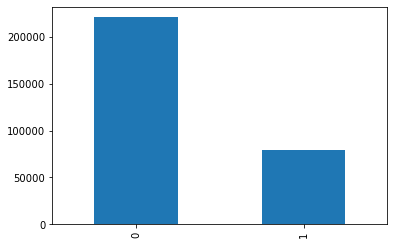

In [9]:
# target distribution bar chart
df['target'].value_counts().plot(kind='bar')

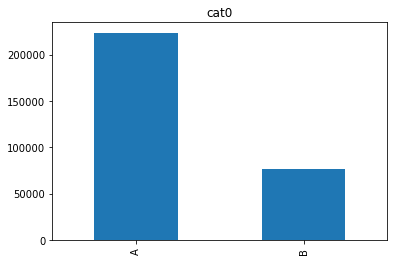

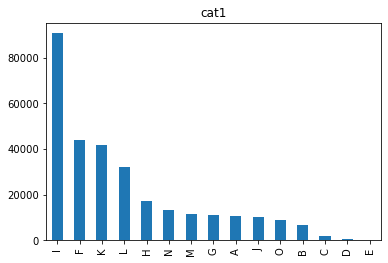

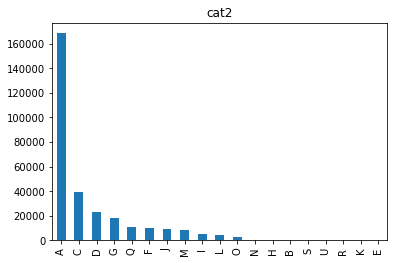

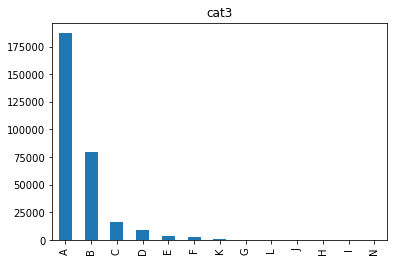

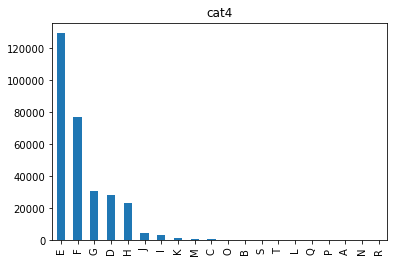

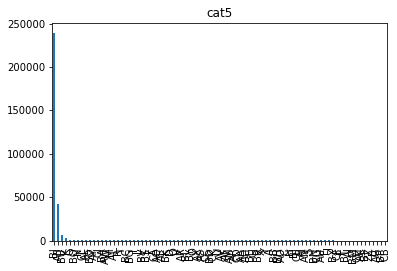

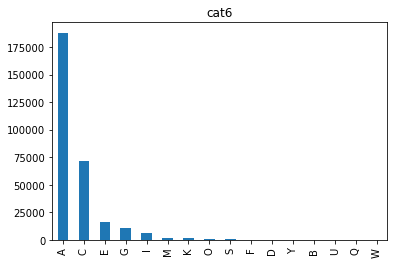

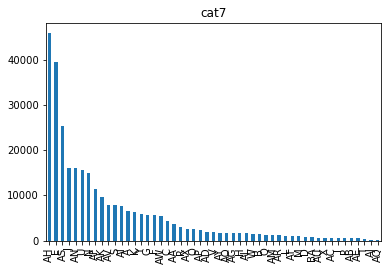

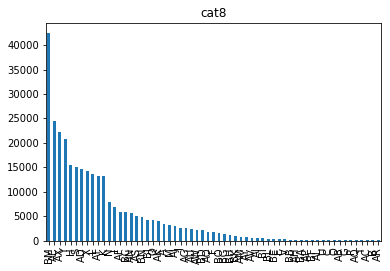

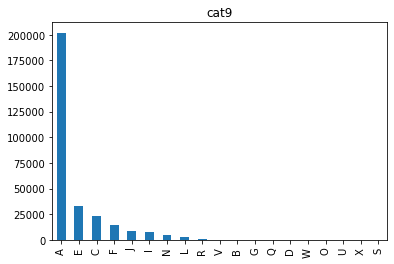

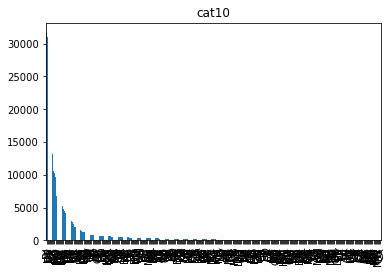

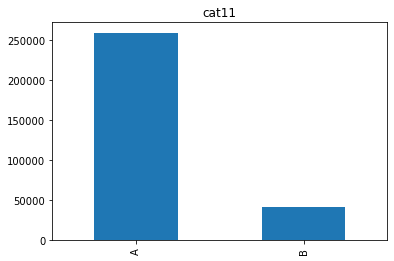

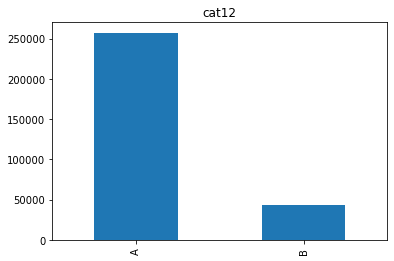

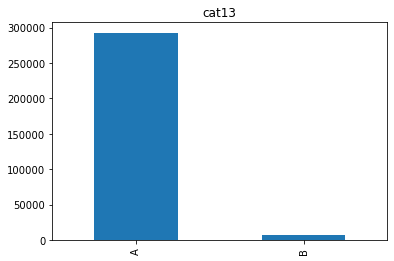

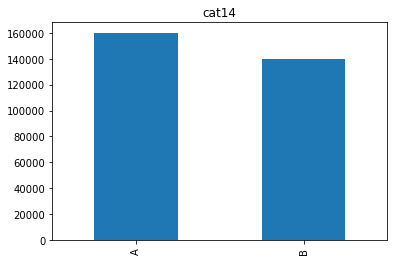

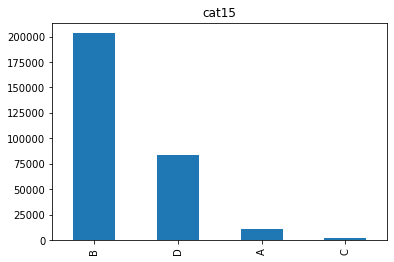

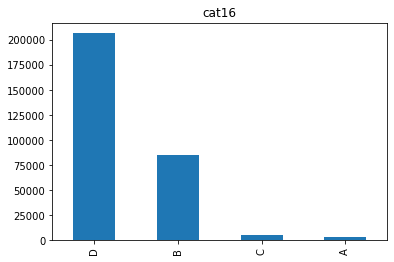

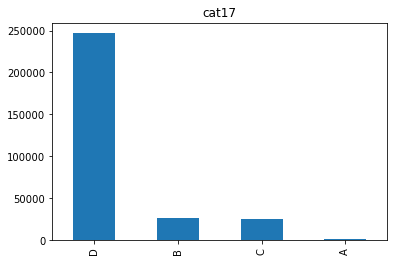

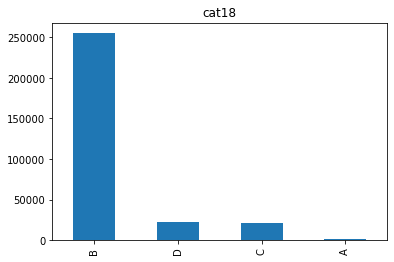

In [10]:
for column in cat_columns:
    df[column].value_counts().plot(kind='bar')
    plt.title(column)
    plt.show()

/home/studio-lab-user/.conda/envs/stat/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


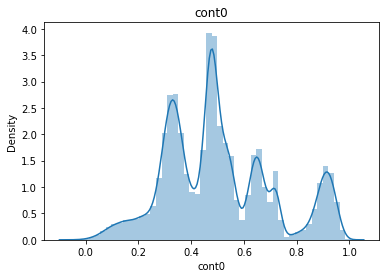

/home/studio-lab-user/.conda/envs/stat/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


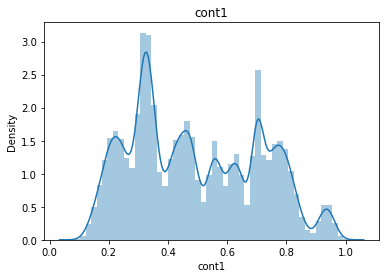

/home/studio-lab-user/.conda/envs/stat/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


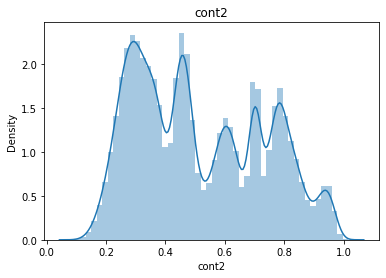

/home/studio-lab-user/.conda/envs/stat/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


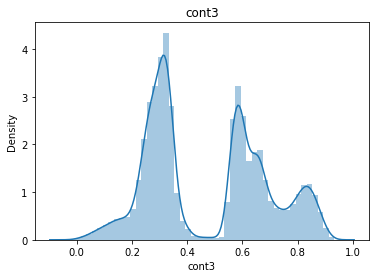

/home/studio-lab-user/.conda/envs/stat/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


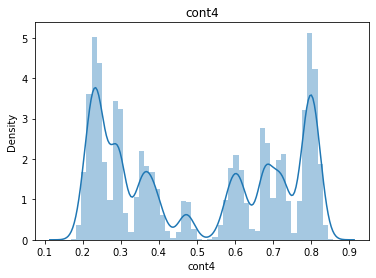

/home/studio-lab-user/.conda/envs/stat/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


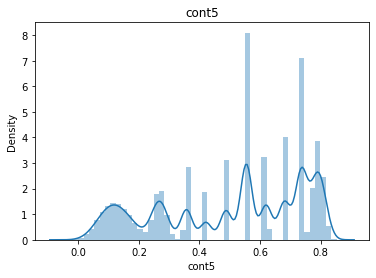

/home/studio-lab-user/.conda/envs/stat/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


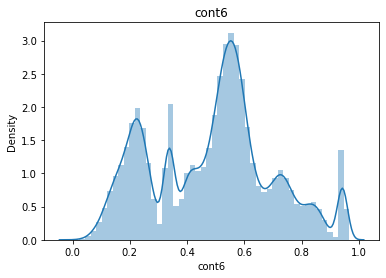

/home/studio-lab-user/.conda/envs/stat/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


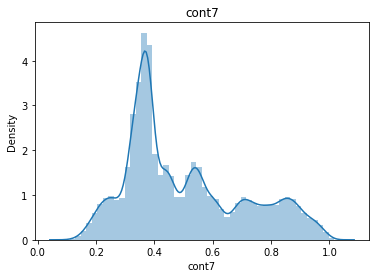

/home/studio-lab-user/.conda/envs/stat/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


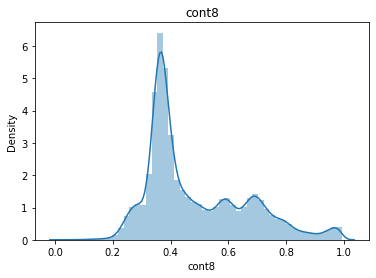

/home/studio-lab-user/.conda/envs/stat/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


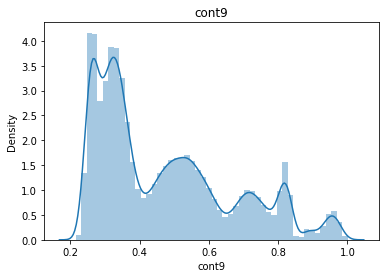

/home/studio-lab-user/.conda/envs/stat/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


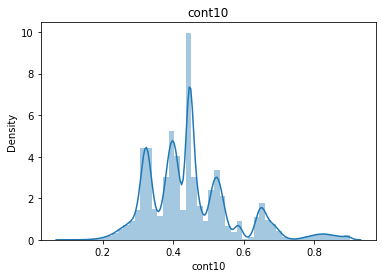

In [11]:
# Checking the distribution of continuous features
# kde plot
import seaborn as sns
for column in num_columns:
    sns.distplot(df[column])
    plt.title(column)
    plt.show()




In [12]:
# label encoding
from sklearn.preprocessing import LabelEncoder
for column in cat_columns:
    le=LabelEncoder()
    df[column]=le.fit_transform(df[column])
df=df.drop(['id'],axis=1)
# train test split
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(df.drop('target',axis=1),df['target'],test_size=0.2,random_state=43)

In [15]:

# trying logistic regression
from sklearn.linear_model import LogisticRegression
# import roc_auc_score
from sklearn.metrics import roc_auc_score
logreg=LogisticRegression()
logreg.fit(X_train,y_train)
y_pred=logreg.predict_proba(X_test)[:,-1]
roc_auc_score(y_test,y_pred)

/home/studio-lab-user/.conda/envs/stat/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.8549096102023672

In [ ]:
# # Splitting and labelencoding the multimodal continuous variables
# for column in  num_columns:
#     df[column]=pd.qcut(df[column],10)
#     # label encode
#     le=LabelEncoder()
#     df[column]=le.fit_transform(df[column])
    
